## Imports

In [1]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from lmfit.models import ExponentialModel

## Function Definitions

Predicted pupil dilation, $d(Y)$, caused by luminance $Y$, is computed with the following equation: $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$

In [11]:
def decay_func(x, a, b):
    return a * np.exp(-x/b)

In [12]:
def pupil_func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Load Data

Load the data from the experimental input files for a single participant.

In [3]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_109.xdf')

dfs = {}
for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    dfs[stream_name] = pd.DataFrame(data_dict)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [4]:
gaze = dfs['GazeStream']
luminance = dfs['LuminanceStream']
stimulus_events = dfs['ExperimentStream']

calibration_events = stimulus_events.loc[(stimulus_events['EventType'] == 'CalibrationColorChange') | (stimulus_events['SceneEvent'] == 'Calibration'), ['time','SceneEvent', 'EventType']]
calibration_events.reset_index(drop=True, inplace=True)
start_time = calibration_events.loc[0, 'time']
print(calibration_events)

pupil_calib_d = gaze.loc[(gaze['MethodID']>98.0) & (gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib = luminance.loc[(luminance['MethodID']>98.0), ['time', 'Luminance']]
lum_calib.reset_index(drop=True, inplace=True)

gaze_luminance_time = np.intersect1d(pupil_calib_d['time'], lum_calib['time'])
pupil_calib_d = pupil_calib_d[pupil_calib_d['time'].isin(gaze_luminance_time)]
lum_calib = lum_calib[lum_calib['time'].isin(gaze_luminance_time)]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib.reset_index(drop=True, inplace=True)


          time          SceneEvent               EventType
0  250149.9771         Calibration             SceneLoaded
1  250155.9845  CalibrationColor_1  CalibrationColorChange
2  250161.9925  CalibrationColor_2  CalibrationColorChange
3  250168.0011  CalibrationColor_3  CalibrationColorChange
4  250174.0085  CalibrationColor_4  CalibrationColorChange
5  250180.0177  CalibrationColor_5  CalibrationColorChange
6  250186.0256  CalibrationColor_6  CalibrationColorChange
7  250192.0343  CalibrationColor_7  CalibrationColorChange


In [17]:
luminance_pupil_diameter = pd.DataFrame()
luminance_pupil_diameter['time'] = lum_calib['time']# //pd.to_timedelta(lum_calib['time'] - start_time, unit='s')
luminance_pupil_diameter['Luminance'] = lum_calib['Luminance']
luminance_pupil_diameter['pupilDiameter'] = 0.5 * (pupil_calib_d['LeftPupilDiameter'] + pupil_calib_d['RightPupilDiameter'])


color1 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[0, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[1, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color2 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[1, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[2, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color3 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[2, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[3, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color4 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[3, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[4, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color5 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[4, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[5, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color6 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[5, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[6, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color7 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[6, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[7, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color8 = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[7, 'time']), ['time', 'Luminance', 'pupilDiameter']]

color1.reset_index(drop=True, inplace=True)
color2.reset_index(drop=True, inplace=True)
color3.reset_index(drop=True, inplace=True)
color4.reset_index(drop=True, inplace=True)
color5.reset_index(drop=True, inplace=True)
color6.reset_index(drop=True, inplace=True)
color7.reset_index(drop=True, inplace=True)
color8.reset_index(drop=True, inplace=True)

color1['time'] = color1['time'] - color1['time'][0]
color2['time'] = color2['time'] - color2['time'][0]
color3['time'] = color3['time'] - color3['time'][0]
color4['time'] = color4['time'] - color4['time'][0]
color5['time'] = color5['time'] - color5['time'][0]
color6['time'] = color6['time'] - color6['time'][0]
color7['time'] = color7['time'] - color7['time'][0]
color8['time'] = color8['time'] - color8['time'][0]

color1=color1.loc[(color1['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color2=color2.loc[(color2['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color3=color3.loc[(color3['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color4=color4.loc[(color4['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color5=color5.loc[(color5['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color6=color6.loc[(color6['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color7=color7.loc[(color7['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
color8=color8.loc[(color8['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]

calibration_data = pd.DataFrame()
calibration_data['Luminance'] = [color1['Luminance'], color2['Luminance'], color3['Luminance'],color4['Luminance'],color5['Luminance'],color6['Luminance'],color7['Luminance'], color8['Luminance']] 
#[color1['Luminance'].mean(), color2['Luminance'].mean(), color3['Luminance'].mean(), color4['Luminance'].mean(), color5['Luminance'].mean(), color6['Luminance'].mean(), color7['Luminance'].mean(), color8['Luminance'].mean()]
calibration_data['PupilDiameter'] = [color1['pupilDiameter'], color2['pupilDiameter'], color3['pupilDiameter'],color4['pupilDiameter'],color5['pupilDiameter'],color6['pupilDiameter'],color7['pupilDiameter'], color8['pupilDiameter']]
#[color1['pupilDiameter'].mean(), color2['pupilDiameter'].mean(), color3['pupilDiameter'].mean(), color4['pupilDiameter'].mean(), color5['pupilDiameter'].mean(), color6['pupilDiameter'].mean(), color7['pupilDiameter'].mean(), color8['pupilDiameter'].mean()]
print(calibration_data)
calibration_data.sort_values(by=['Luminance'], inplace=True)
calibration_data.reset_index(drop=True, inplace=True)


                                           Luminance  \
0  [[0.20557446777820587, 0.20557446777820587, 0....   

                                       PupilDiameter  
0  [[3.2901153564453125, 3.2028121948242188, 3.15...  


Parameters([('exp_amplitude', <Parameter 'exp_amplitude', value=3.827723808288084, bounds=[-inf:inf]>), ('exp_decay', <Parameter 'exp_decay', value=1.4361059811453294, bounds=[-inf:inf]>)])


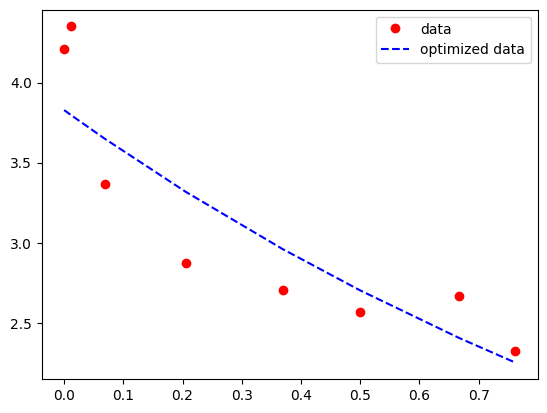

In [13]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]
x_data = calibration_data['Luminance']
y_data = calibration_data['PupilDiameter']

exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y_data, x=x_data)
print(pars)

# bounds=([1, 4, 1], [4, 8, 4])
# #𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$
# p, c, info, msg, ier = curve_fit(func, x_data, y_data, bounds=bounds, full_output=True)
# print(info)
# print(msg)
# print(ier)
# print(np.linalg.cond(c))
# print(np.diag(c))
plt.plot(x_data, y_data, 'o', color ='red', label ="data")
plt.plot(x_data, decay_func(x_data, 3.827723808288084, 1.4361059811453294), '--', color ='blue', label ="optimized data")
plt.legend()
plt.show()